In [23]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [24]:
tiff_file = r'DATA\20240606165451_Dec 2023 E32C6 L4i undiff_20_20x_coloration_work.tif'
base_dir = r"C:\Users\willllllli\Documents\Dr. Z lab\Teratoma_Segmentation\DATA"
save_dir = os.path.join(base_dir, "20240606165451_Dec 2023 E32C6 L4i undiff")

In [25]:
def read_layers(filename):
    img_array = []
    with tifffile.TiffFile(filename) as tif:
        for i, page in enumerate(tif.pages):
            name = page.tags.get('PageName')
            layer_name = name.value if name else f"Layer {i}"
            img = page.asarray()
            print(f"Layer {i}: {layer_name} {img.shape}")   
            img_array.append(page.asarray());        
    return np.array(img_array[0]), np.stack(img_array[1:])

def compute_mean_std(img):
    # img: H×W×C
    mean = img.mean(axis=(0,1))
    std  = img.std(axis=(0,1))
    return mean.tolist(), std.tolist()


In [26]:
colored, segmentation = read_layers(tiff_file)

Layer 0: 20240606165451_Dec 2023 E32C6 L4i undiff_20_20x.tif (22011, 33277, 3)
Layer 1: GI (22011, 33277, 4)
Layer 2: Cartilage (22011, 33277, 4)
Layer 3: RPE (22011, 33277, 4)
Layer 4: Neural (22011, 33277, 4)


In [27]:
# mean, std = compute_mean_std(colored)
# print(np.divide(mean, 255), np.divide(std, 255))

In [28]:
binary_seg = []
for layer in segmentation:
    binary = (layer > 0).any(axis=-1).astype(np.uint8)
    binary_seg.append(binary)
binary_seg = np.array(binary_seg)
binary_seg = np.expand_dims(binary_seg, axis=-1)  # shape: (4, H, W, 1)

print("colored segmentation shape: ", segmentation.shape)
print("binarized segmentation shape: ",binary_seg.shape)

colored segmentation shape:  (4, 22011, 33277, 4)
binarized segmentation shape:  (4, 22011, 33277, 1)


In [29]:
tile_h, tile_w = 512, 512
n_layers, h, w, c = binary_seg.shape
n_height = h // tile_h
n_width = w // tile_w
print(n_layers, h, w, c)
print(n_width, n_height)

colored_tiles = []
segmentation_tiles = []

for k in range(n_layers):
    layer_seg_tiles = []
    for i in range(n_height):
        for j in range(n_width):
            if k == 0:
                tile_colored = colored[i*tile_h:(i+1)*tile_h, j*tile_w:(j+1)*tile_w, :]
                colored_tiles.append(tile_colored)
            tile_seg = binary_seg[k, i*tile_h:(i+1)*tile_h, j*tile_w:(j+1)*tile_w, :]
            layer_seg_tiles.append(tile_seg)
    segmentation_tiles.append(layer_seg_tiles)

colored_tiles = np.array(colored_tiles)  # (2688, 512, 512, 3)
segmentation_tiles = np.array(segmentation_tiles)  # (4, 2688, 512, 512, 1)

print(colored_tiles.shape)
print(segmentation_tiles.shape)


4 22011 33277 1
64 42
(2688, 512, 512, 3)
(4, 2688, 512, 512, 1)


In [ ]:
has_structure = set()
for tissue in segmentation_tiles:
    for idx, tile in enumerate(tissue):
        if np.any(tile):
            has_structure.add(idx)

has_structure = sorted(list(has_structure))

colored_tiles = colored_tiles[has_structure]
segmentation_tiles = segmentation_tiles[:, has_structure]

In [33]:
print(colored_tiles.shape)
print(segmentation_tiles.shape)

(641, 512, 512, 3)
(4, 641, 512, 512, 1)


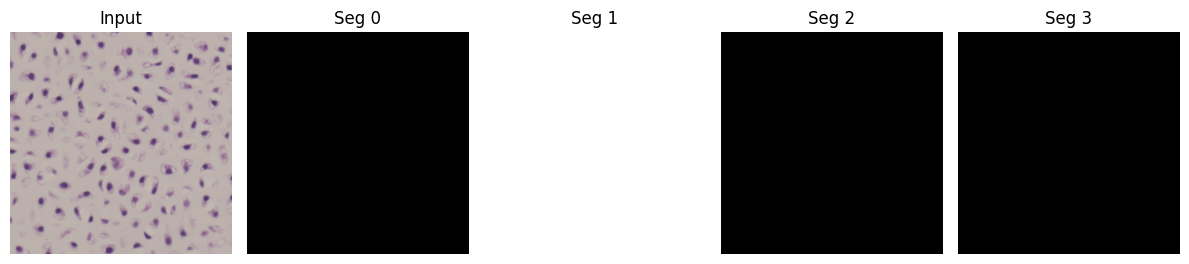

In [38]:
tile_idx = 404
plt.figure(figsize=(12, 3))
plt.subplot(1, 5, 1)
plt.imshow(colored_tiles[tile_idx].squeeze())
plt.title("Input")
plt.axis('off')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(segmentation_tiles[i, tile_idx].squeeze(), cmap='grey', vmin=0, vmax=1)
    plt.title(f"Seg {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [34]:
# Create subfolders
os.makedirs(os.path.join(save_dir, "input"), exist_ok=True)

seg_names = ["GI", "Cartilage", "RPE", "Neural"]
for name in seg_names:
    os.makedirs(os.path.join(save_dir, "segmentation", name), exist_ok=True)

# Save input tiles
for i, tile in enumerate(colored_tiles):
    out_path = os.path.join(save_dir, "input", f"tile_{has_structure[i]:04d}.png")
    cv2.imwrite(out_path, cv2.cvtColor(tile, cv2.COLOR_RGB2BGR))

# Save segmentation tiles
for layer_idx, name in enumerate(seg_names):
    for i, tile in enumerate(segmentation_tiles[layer_idx]):
        out_path = os.path.join(save_dir, "segmentation", name, f"tile_{has_structure[i]:04d}.png")
        cv2.imwrite(out_path, tile.squeeze())
